In [1]:
import numpy as np
import pandas as pd
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Initialize lists to store tensors for source positions, density values, and class labels
source_positions_tensors = []
density_values_tensors = []
class_tensors = []

# Initialize tensors for source positions and density values
source_positions_tensor = None
density_values_tensor = None
class_tensor = None

# Open the HDF5 file in read mode
with h5py.File("Smoke Flow Data.h5", "r") as hf:

    # Iterate over each smoke detector position
    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos
        
        # Iterate over the time steps with a sliding window
        for source_group_name in hf:
            total_steps = 501  # Total number of steps
            window_size = 300
            # Access the group corresponding to the source position
            source_group = hf[source_group_name]

            # Extract the source position value from the group name
            source_position_str = source_group_name.split('-')[-1]

            # Convert the source position string to a numerical data type (e.g., float)
            source_position = float(source_position_str)

            # Access the 'density' dataset within the group
            density_dataset = source_group['density']

            # Iterate over the sliding windows
            for start_idx in range(total_steps - window_size):
                # Retrieve the density values at the specified position (x, y) for the current window
                density_values_at_position = density_dataset[start_idx : start_idx + window_size, int(x), int(y), 0]
                
                # Convert density values to PyTorch tensor
                density_values_tensor_batch = torch.tensor(density_values_at_position)
                source_position_tensor_batch = torch.tensor(source_position)
                
                # Calculate the class label based on the source position
                class_label = int(source_position // 10) - 1
                # print(class_label)
                # Create class tensor based on the class label
                class_tensor_batch = torch.tensor(class_label)

                # Concatenate batch tensors
                if source_positions_tensor is None:
                    source_positions_tensor = source_position_tensor_batch.unsqueeze(0)
                    density_values_tensor = density_values_tensor_batch.unsqueeze(0)
                    class_tensor = class_tensor_batch.unsqueeze(0)
                else:
                    source_positions_tensor = torch.cat((source_positions_tensor, source_position_tensor_batch.unsqueeze(0)), dim=0)
                    density_values_tensor = torch.cat((density_values_tensor, density_values_tensor_batch.unsqueeze(0)), dim=0)
                    class_tensor = torch.cat((class_tensor, class_tensor_batch.unsqueeze(0)), dim=0)

            # Append the tensors to the lists after processing all sliding windows for each source position
            source_positions_tensors.append(source_positions_tensor)
            density_values_tensors.append(density_values_tensor)
            class_tensors.append(class_tensor)

# You now have the source positions, density values, and class labels as tensors with sliding windows
print("Source positions tensor shape:", source_positions_tensor.shape)
print("Density values tensor shape:", density_values_tensor.shape)
print("Class tensor shape:", class_tensor.shape)

Source positions tensor shape: torch.Size([3618])
Density values tensor shape: torch.Size([3618, 300])
Class tensor shape: torch.Size([3618])


In [3]:
density_tensor = density_values_tensor.reshape(1809,2,-1)
source_tensor = source_positions_tensor.view(1809,-1)
class_tensor = class_tensor.view(1809,-1)
class_tensor[~(class_tensor[:,0] == class_tensor[:,1])]
class_tensor = class_tensor[:,0]

In [10]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import torch.nn as nn

def plot_fft_demo(some_index):
 
    # Compute FFT of the signal
    fft_signal = torch.fft.fft(density_tensor[some_index, 0, :], dim=0)
    fft_signals = fft_signal.abs()
    plt.figure(figsize=(10, 5))

    # Plot original signal
    plt.subplot(121)
    plt.plot(density_tensor[some_index, 0, :])
    plt.title('Original Signal')
    plt.xlabel('Time')
    plt.ylabel('Density')

    # Plot FFT spectrum
    plt.subplot(122)
    # plt.plot(torch.arange(fft_signals.shape[0]), torch.abs(fft_signal))
    plt.plot(torch.arange(fft_signals.shape[0]), fft_signals)
    plt.title('Spectrum of Original signal')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


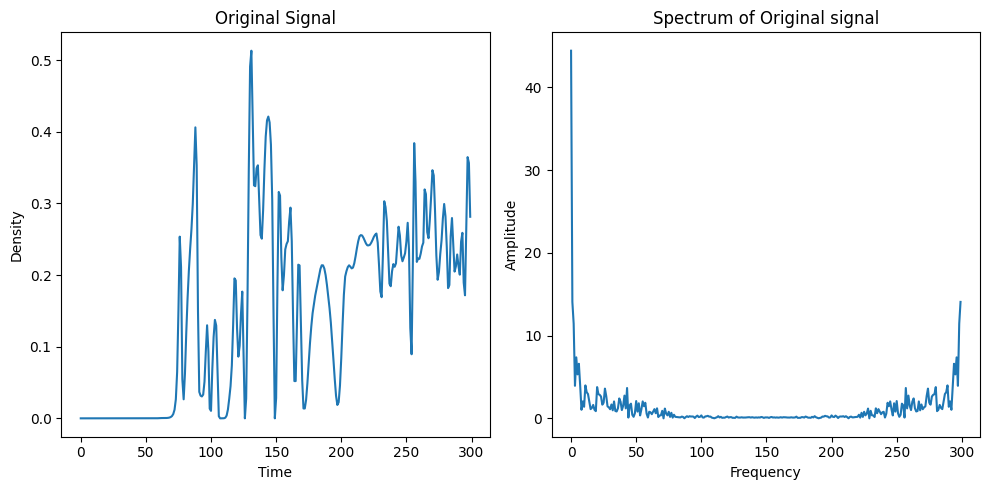

In [11]:
# Example usage:
plot_fft_demo(some_index = 600)

In [6]:
# pip install torchaudio

In [31]:
import torch
import torch.fft
import matplotlib.pyplot as plt
import torchaudio.functional as F

# Example signal parameters
some_index = 600  # Example index, adjust as needed
sample_rate = 300  # Example sample rate, adjust as needed
cutoff_freq = 3 # Example cutff frequency, adjust as needed

### Cpmputing orginal signal FFT
fft_signal = torch.fft.fft(density_tensor[some_index, 0, :], dim=0)
fft_signals = fft_signal.abs()

orginal_signal = torch.unsqueeze(density_tensor[some_index, 0, :], dim=0)

### Cpmputing low pass filter for the orginla signal
low_filter = F.lowpass_biquad(orginal_signal, sample_rate, cutoff_freq)
# print(low_filter)

### Conputing low pass filter FFT
fft_signall = torch.fft.fft(low_filter.squeeze(), dim=0)
fft_signalsl = torch.abs(fft_signall)



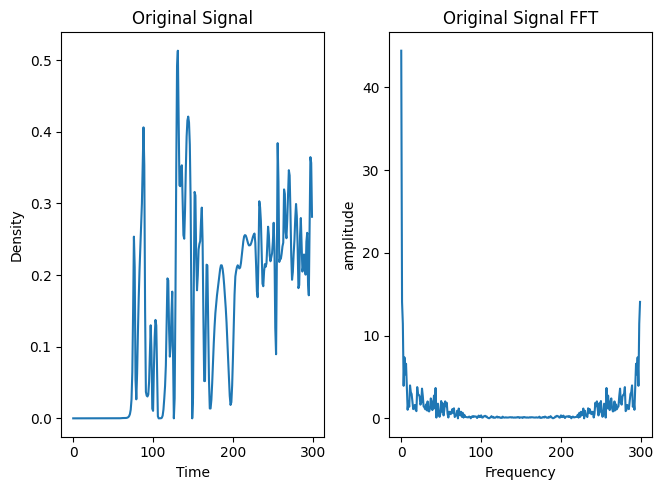

In [32]:
# Plot original signal
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.plot(density_tensor[some_index, 0, :])
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Density')

 ##n Plot FFT for the non filtered data
plt.subplot(132)
plt.plot(torch.arange(fft_signals.shape[0]), fft_signals)
plt.title('Original Signal FFT')
plt.xlabel('Frequency')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show()

/var/folders/b2/75ym41yx3ysd_01qq9wv2q1h0000gn/T/ipykernel_8205/1524961907.py:15: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


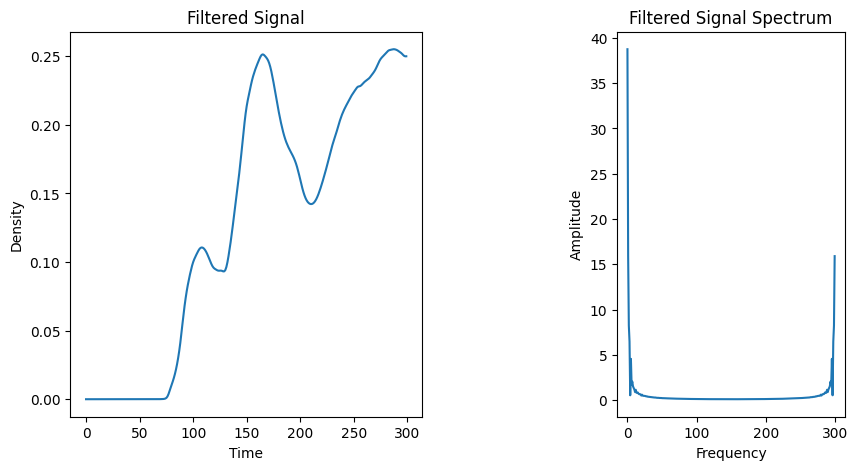

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(torch.arange(low_filter.shape[1]).numpy(), low_filter.squeeze().numpy())
# plt.plot( torch.arange(low_filter.shape[1]),low_filter)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Density')

# Plot filtered signal and its FFT
plt.subplot(133)
plt.plot(torch.arange(fft_signalsl.shape[0]), fft_signalsl)
plt.title('Filtered Signal Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Density')

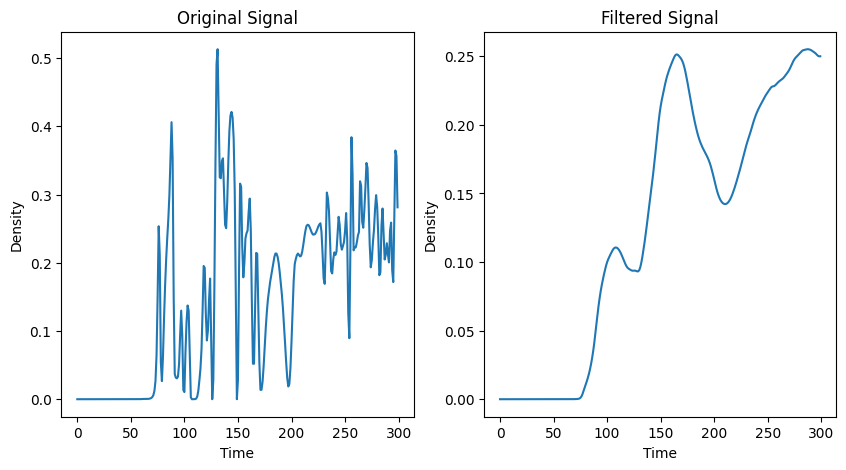

In [38]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(density_tensor[some_index, 0, :])
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Density')

plt.subplot(122)
plt.plot(torch.arange(low_filter.shape[1]).numpy(), low_filter.squeeze().numpy())
# plt.plot( torch.arange(low_filter.shape[1]),low_filter)
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Density')

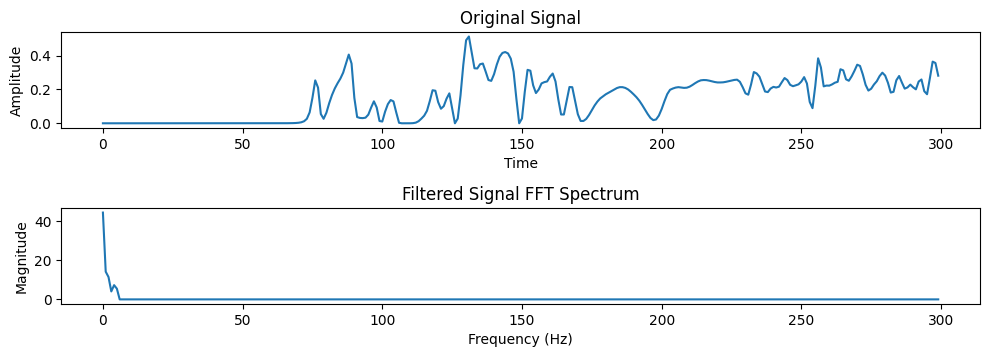

In [20]:

import torch
import torch.fft
import matplotlib.pyplot as plt

# Example signal parameters
some_index = 600  # Example index, adjust as needed
sample_rate = 3000  # Example sample rate, adjust as needed
cutoff_freq = 30  # Example cutoff frequency, adjust as needed

# Compute the original signal
original_signal = density_tensor[some_index, 0, :]

# Apply low-pass filter using the difference equation
filtered_signal = torch.zeros_like(original_signal)
filtered_signal[0] = original_signal[0]  # First element remains the same
for i in range(1, len(original_signal)):
    filtered_signal[i] = (original_signal[i] + original_signal[i-1]) / 2

# Compute FFT of the filtered signal
fft_filtered_signal = torch.fft.fft(filtered_signal, dim=0)
fft_filtered_signal = fft_filtered_signal.abs()

# Apply cutoff frequency to the FFT of the filtered signal
# Keep only the low-frequency components up to the cutoff frequency
freq_bins = torch.fft.fftfreq(len(fft_filtered_signal), d=1/sample_rate)
cutoff_index = int(cutoff_freq * len(freq_bins) / (sample_rate / 2))
fft_filtered_signal[cutoff_index:] = 0


# Plotting
plt.figure(figsize=(10, 5))

# Plot original signal
plt.subplot(311)
plt.plot(original_signal)
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# # Plot filtered signal in time domain
# plt.subplot(312)
# plt.plot(final_filtered_signal)
# plt.title('Filtered Signal')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# Plot FFT spectrum of filtered signal
plt.subplot(312)
plt.plot(torch.arange(fft_filtered_signal.shape[0]), fft_filtered_signal )
plt.title('Filtered Signal FFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


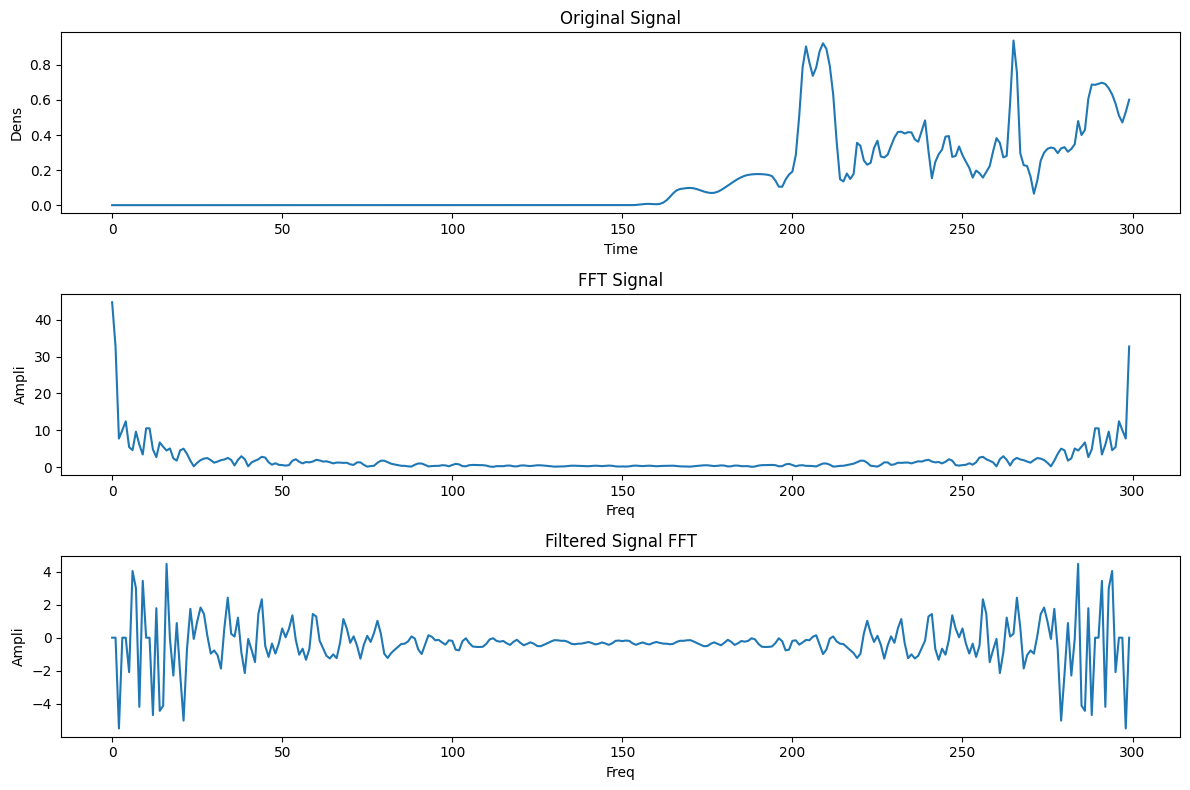

In [164]:
import torch
import torch.fft
import matplotlib.pyplot as plt

# Example signal parameters
some_index = 400  # Example index, adjust as needed
cutoff_freq = 10  # Example cutoff frequency, adjust as needed

# Compute the original signal
original_signal = density_tensor[some_index, 0, :]

# Compute FFT of the original signal
fft_original_signal = torch.fft.fft(original_signal, dim=0)
fft_signal = fft_original_signal.abs()

cutoff_frequency = cutoff_freq 
# Filter FFT signal
fft_filtered_signal = filter_fft_signal(fft_original_signal, cutoff_frequency)
# fft_original_signal = fft_filtered_signal.abs()
# print(fft_filtered_signal)

# Plotting
plt.figure(figsize=(12, 8))

# Plot FFT spectrum of original signal
plt.subplot(311)
plt.plot(original_signal )
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Dens')

# Plot filtered signal in time domain
plt.subplot(312)
plt.plot(torch.arange(fft_signal .shape[0]), fft_signal)
plt.title('FFT Signal')
plt.xlabel('Freq')
plt.ylabel('Ampli')

# Plot FFT spectrum of filtered signal
plt.subplot(313)
# plt.plot(freq_bins.numpy(), torch.abs(fft_filtered_signal))
plt.plot(torch.arange(fft_filtered_signal .shape[0]), fft_filtered_signal)
plt.title('Filtered Signal FFT')
plt.xlabel('Freq')
plt.ylabel('Ampli')

plt.tight_layout()
plt.show()


In [158]:
def filter_fft_signal(fft_signal, cutoff_frequency):
    frequencies = fft_signal.abs()
    # print(frequencies)
    mask = frequencies <= cutoff_frequency
    filtered_fft_signal = fft_signal.clone()
    filtered_fft_signal[~mask] = 0
    # print(filtered_fft_signal)
    return filtered_fft_signal